# Used Car Price Prediction model using Decision Tree Regressor

### Importing the libraries

In [1]:
import time
start_time = time.time()
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("vehicles.csv")
# Drop the columns that are not useful for our analysis
data.drop(['url', 'region', 'region_url', 'VIN', 'image_url', 'description', 'county','state','lat','long','posting_date','paint_color'], axis=1, inplace=True)

In [4]:
execute_time = 0
df = data.copy()
df.describe()
df.shape

(426880, 14)

## Data Cleaning
### Removing Outliners for price

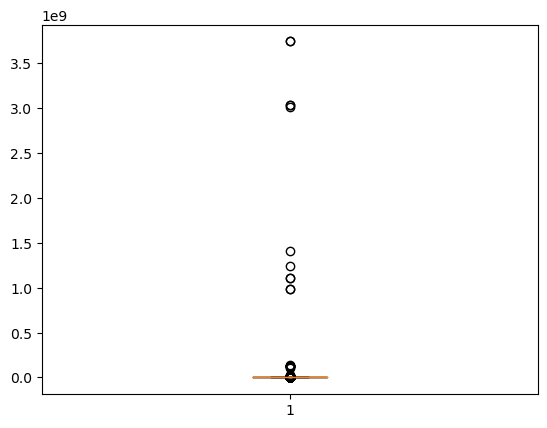

In [89]:
#Plotting box plot for price
price_plot = plt.boxplot(df["price"])
plt.show()

In [90]:
#Removing outliners from price
if execute_time == 0:
    quantile1, quantile2= df['price'].quantile(0.10),df['price'].quantile(0.99)
    df = df[(df['price'] >= quantile1) & (df['price'] <= quantile2)]
    execute_time+= 1
print(quantile1, quantile2)


500.0 66995.0


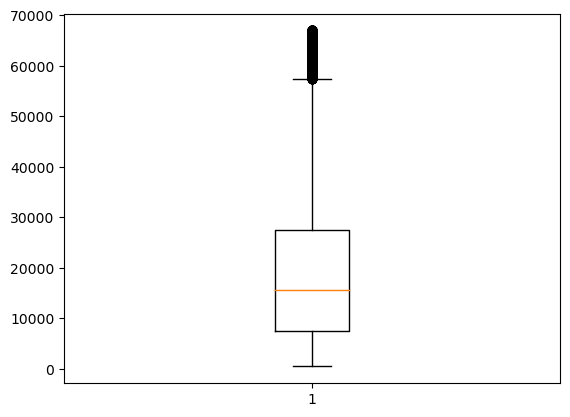

In [91]:
#Plotting box plot for price after removing outliners
price_plot = plt.boxplot(df["price"])
plt.show()

### Removing Outliners for odometer

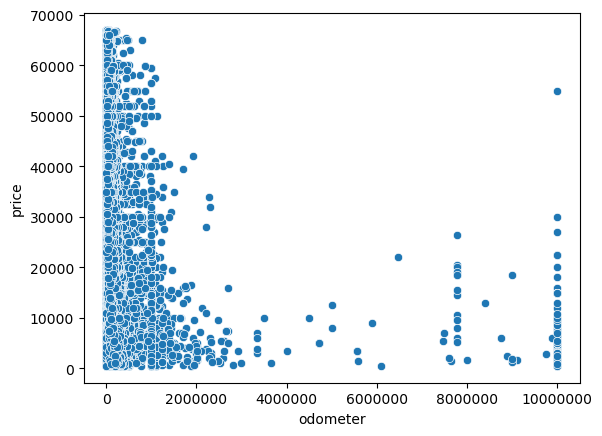

In [92]:
#Plotting odometer and price to identify the outliners
def plot_odometer_price():
    odometer_plot = sns.scatterplot(x="odometer", y="price", data=df)
    odometer_plot.get_xaxis().get_major_formatter().set_scientific(False)
    odometer_plot.get_yaxis().get_major_formatter().set_scientific(False)
plot_odometer_price()

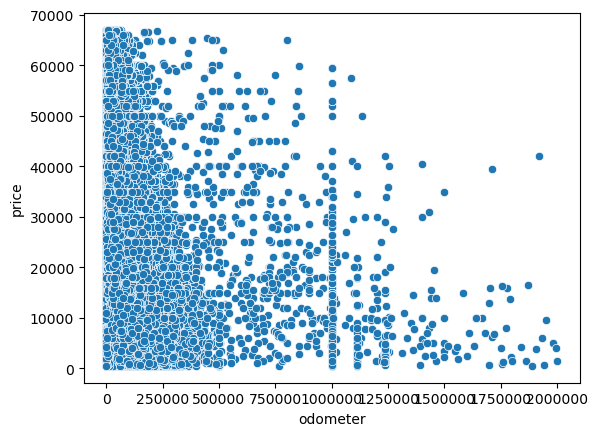

In [93]:
#Removing vehicles which has odometer value as 0 as they are used cars
df = df[df["odometer"] != 0]
#Based on above graph removing values > 2000000
df = df[df['odometer'] < 2000000]
#Plotting the graph after removing outliners
plot_odometer_price()


### Removing Outliners for year

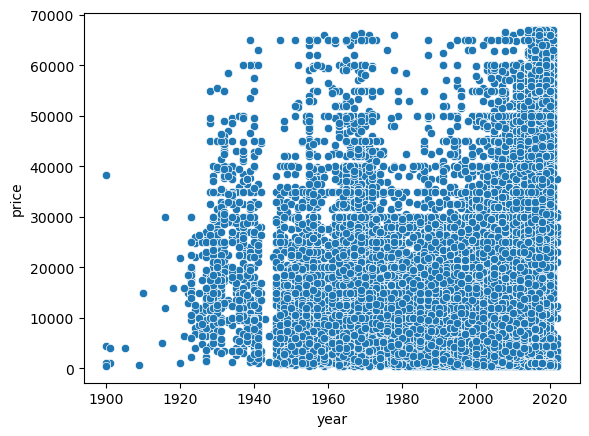

In [94]:
# Removing vehicles which does not have year in it
df=df.dropna(subset=['year'])
#Plotting year and price to identify the outliners
year_plot = sns.scatterplot(x="year", y="price", data=df)

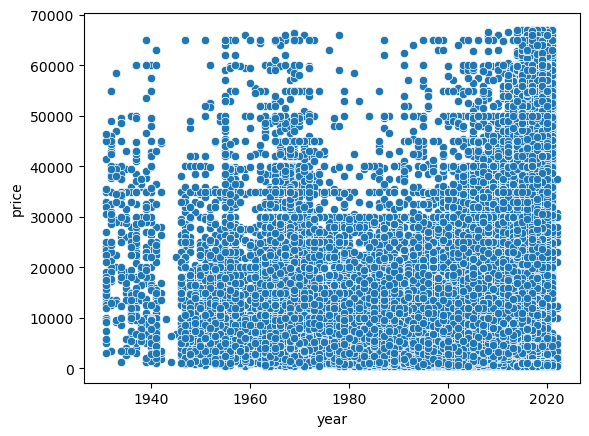

In [95]:
#Plotting the graph after removing outliners
df = df[df['year'] > 1930]
year_plot = sns.scatterplot(x="year", y="price", data=df)

In [96]:
#Listing Null values
def percent_null_values():
    print(df.isnull().sum()/len(df)*100)
percent_null_values()

id               0.000000
price            0.000000
year             0.000000
manufacturer     3.669410
model            1.121704
condition       37.401382
cylinders       40.793891
fuel             0.551941
odometer         0.000000
title_status     1.632149
transmission     0.397132
drive           30.602799
size            71.613210
type            21.634756
dtype: float64


### Enhancing data quality


In [97]:
#Dropping columns which have null values of percentage less than 5
df=df.dropna(subset=['title_status','fuel','transmission','model','manufacturer'])
#Dropping size column as it has 71 percent missing values
if('size' in list(df.columns)):
    df.drop(["size"],axis=1, inplace=True)
    percent_null_values()

id               0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
model            0.000000
condition       37.274462
cylinders       40.793688
fuel             0.000000
odometer         0.000000
title_status     0.000000
transmission     0.000000
drive           29.806276
type            21.230239
dtype: float64


### Filling missing values using approximation

In [98]:
need_to_be_filled = ['drive','type','cylinders']
df_copy = df.copy()
df_without_na = df_copy.dropna(subset=need_to_be_filled)
df_without_na['concatenated'] = df_copy["drive"] + "@" + df_copy["type"] + "@" + df_copy["cylinders"]
df_to_be_updated = pd.DataFrame(columns=df_copy.columns)
for manufacturer in list(df_without_na["manufacturer"].unique()):
    temp_1 = df_without_na[df_without_na["manufacturer"] == manufacturer]
    temp_1_na = df_copy[df_copy["manufacturer"] == manufacturer]
    for model in list(temp_1["model"].unique()):
        temp_2 = temp_1[temp_1["model"] == model]
        temp_2_na = temp_1_na[temp_1_na["model"] == model]
        for year in list(temp_2["year"].unique()):
            temp_3 = temp_2[temp_2["year"] == year]
            temp_3_na = temp_2_na[temp_2_na["year"] == year]
            drive_type_cylinders = set(temp_3['concatenated'].unique())
            for ind,field in enumerate(need_to_be_filled):
                indices = list(range(0,len(need_to_be_filled)))
                indices.remove(ind)
                for value in drive_type_cylinders:
                    v_split = value.split("@")
                    selected_rows =  temp_3_na[(temp_3_na[field].isna()) & (temp_3_na[need_to_be_filled[indices[0]]] == v_split[indices[0]]) & (temp_3_na[need_to_be_filled[indices[1]]] == v_split[indices[1]])]
                    selected_rows.loc[:, field] = v_split[ind]
                    if selected_rows.shape[0] > 0:
                        df_to_be_updated = pd.concat([df_to_be_updated, selected_rows], ignore_index=True)

df = pd.concat([df,df_to_be_updated],ignore_index=True)
df.drop_duplicates(subset='id', keep='last',inplace=True)

In [99]:
percent_null_values()
df.reset_index(drop=True,inplace=True)

id               0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
model            0.000000
condition       37.274462
cylinders       32.784326
fuel             0.000000
odometer         0.000000
title_status     0.000000
transmission     0.000000
drive           26.665502
type            17.785787
dtype: float64


In [100]:
#This step is because values Nan Values where getting encoded when using labelencoder

df_labeled = df.copy()
le=LabelEncoder()
columns_to_be_imputed = ["condition", "cylinders", "drive","type"]
columns_to_be_labeled = ['manufacturer', 'model','fuel', 'title_status', 'transmission',"condition", "cylinders", "drive","type"]
#for imputing purpose
for col in columns_to_be_labeled:
    if col in columns_to_be_imputed:
        set_index = df_labeled[df_labeled[col].isnull()].index.to_list()[0]
        df_labeled[col] = le.fit_transform(df_labeled[col])
        df_labeled.loc[df_labeled[col] == df_labeled[col][set_index],col] = np.NaN
    else:
         df_labeled[col] = le.fit_transform(df_labeled[col])

In [101]:
df_labeled

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type
0,7316743432,30990,2017.0,38,18417,2.0,6.0,2,41124.0,0,2,NaN,8.0
1,7316356412,15000,2013.0,13,7996,0.0,5.0,2,128000.0,0,0,2.0,10.0
2,7316343444,27990,2012.0,14,15767,2.0,6.0,2,68696.0,0,2,0.0,8.0
3,7316304717,34590,2016.0,7,16017,2.0,5.0,2,29499.0,0,2,0.0,8.0
4,7316285779,35000,2019.0,38,17222,0.0,5.0,2,43000.0,0,0,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
349049,7310624989,30000,1972.0,9,604,3.0,5.0,2,87579.0,0,1,2.0,4.0
349050,7311117485,10000,1980.0,9,855,2.0,5.0,2,87365.0,0,1,2.0,3.0
349051,7306788460,22900,1980.0,9,855,2.0,5.0,2,61670.0,0,1,2.0,3.0
349052,7315356636,7000,1983.0,9,855,0.0,5.0,2,109000.0,0,0,2.0,3.0


### Filling missing value with HistGradientBoostingClassifier algorithm

In [102]:
df_missing = df_labeled[df_labeled.isnull().any(axis=1)]
df_not_missing = df_labeled.dropna()
for col in columns_to_be_imputed:
# Split the dataset into two parts: one with missing values and the other without missing values
# Define the features and target variables
    columns = df_labeled.columns.to_list()
    columns.remove(col)
    variables = df_labeled.columns.to_list()
    target = col
# Create a HistGradientBoostingClassifier model
    model = HistGradientBoostingClassifier()
# Train the model on the part of the dataset without missing values
    model.fit(df_not_missing[variables], df_not_missing[target])
    df_missing[target] = model.predict(df_missing[variables])
df_imputed = pd.concat([df_missing,df_not_missing],ignore_index=True)

In [103]:
df_imputed

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type
0,7316743432,30990,2017.0,38,18417,2.0,6.0,2,41124.0,0,2,1.0,8.0
1,7315770394,24590,2017.0,7,16084,2.0,5.0,2,40784.0,0,2,1.0,8.0
2,7315715960,27990,2014.0,38,17267,2.0,5.0,4,17805.0,0,2,1.0,8.0
3,7315275975,33590,2014.0,38,18408,2.0,5.0,4,55251.0,0,2,1.0,8.0
4,7315275942,30990,2019.0,13,14282,2.0,5.0,4,1834.0,0,2,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
349049,7310624989,30000,1972.0,9,604,3.0,5.0,2,87579.0,0,1,2.0,4.0
349050,7311117485,10000,1980.0,9,855,2.0,5.0,2,87365.0,0,1,2.0,3.0
349051,7306788460,22900,1980.0,9,855,2.0,5.0,2,61670.0,0,1,2.0,3.0
349052,7315356636,7000,1983.0,9,855,0.0,5.0,2,109000.0,0,0,2.0,3.0


In [104]:
#checking percentage of null values
print(df_imputed.isnull().sum()/len(df_imputed)*100)

id              0.0
price           0.0
year            0.0
manufacturer    0.0
model           0.0
condition       0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
type            0.0
dtype: float64


In [105]:
df_labeled_without_na = df_labeled.dropna()

## Data Exploration 
### Price vs Other Parameters

<Figure size 1500x1500 with 0 Axes>

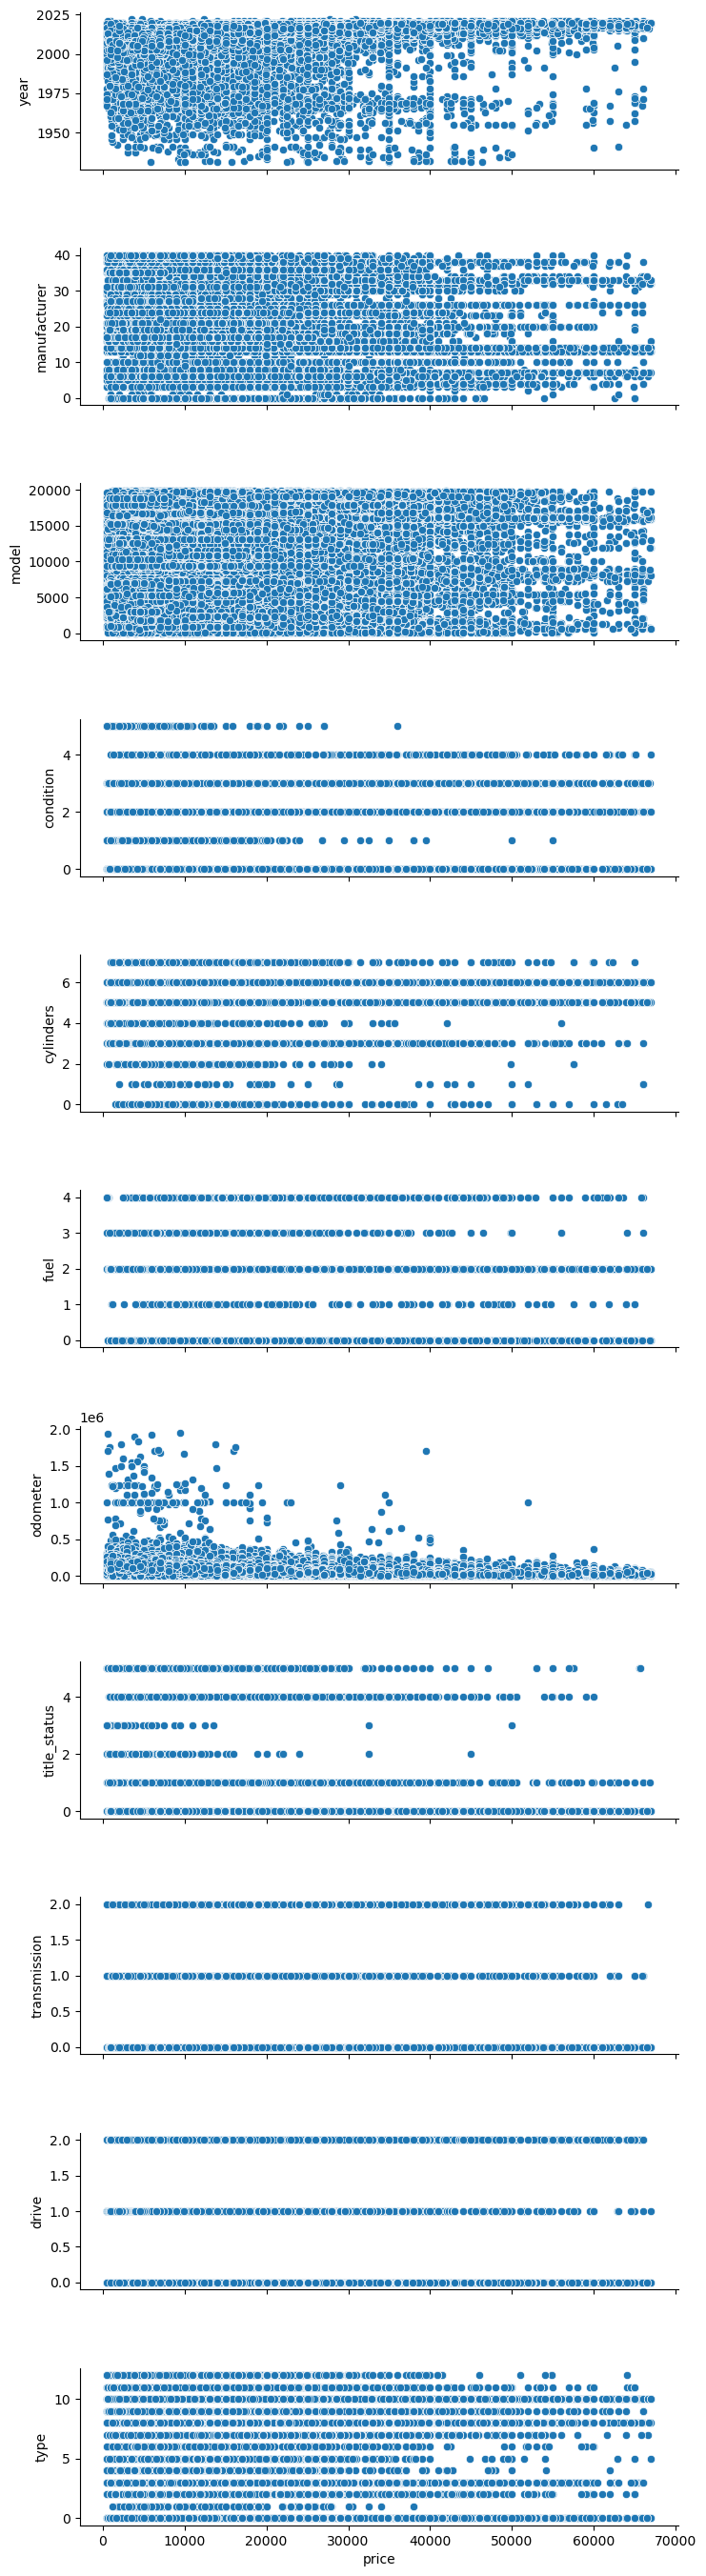

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 15))

# Select all columns except 'price' for the y-axis
y_vars = ['year', 'manufacturer', 'model', 'condition', 'cylinders',
          'fuel', 'odometer', 'title_status', 'transmission', 'drive',
          'type']

# Use pairplot to create scatter matrix
g = sns.pairplot(data=df_labeled_without_na, x_vars=['price'], y_vars=y_vars, height=2.5, aspect=3)

# Adjust spacing between subplots
g.fig.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()


### Correlation Matrix

In [107]:
corr=df_labeled_without_na.corr()
corr.style.background_gradient(cmap='coolwarm')

,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type
year,1.000000,0.027849,0.050105,0.032317,-0.132874,0.091842,-0.313608,0.027895,0.179926,-0.205469,0.024970
manufacturer,0.027849,1.000000,-0.014153,-0.027271,-0.238399,0.002893,0.041766,0.022688,-0.013643,-0.103209,0.019840
model,0.050105,-0.014153,1.000000,0.004956,0.101321,0.036343,0.005271,-0.020293,0.015145,-0.163121,-0.102149
condition,0.032317,-0.027271,0.004956,1.000000,0.089825,0.074792,-0.090858,0.013964,0.253923,0.036582,0.052913
cylinders,-0.132874,-0.238399,0.101321,0.089825,1.000000,-0.083772,0.004906,-0.074253,0.158803,-0.020751,0.019699
fuel,0.091842,0.002893,0.036343,0.074792,-0.083772,1.000000,-0.165873,-0.016867,0.213800,0.055930,-0.112532
odometer,-0.313608,0.041766,0.005271,-0.090858,0.004906,-0.165873,1.000000,-0.031874,-0.347403,-0.055901,-0.000292
title_status,0.027895,0.022688,-0.020293,0.013964,-0.074253,-0.016867,-0.031874,1.000000,-0.072908,-0.001673,0.003025
transmission,0.179926,-0.013643,0.015145,0.253923,0.158803,0.213800,-0.347403,-0.072908,1.000000,0.029469,0.009750
drive,-0.205469,-0.103209,-0.163121,0.036582,-0.020751,0.055930,-0.055901,-0.001673,0.029469,1.000000,0.127118


# Prediction Model using DecisionTreeRegressor

### Using Imputed Dataset

In [108]:
# Select the predictor variables
# X = df[['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
# ].values
X = df_imputed.drop(['price','id'], axis=1)
y = df_imputed['price'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a decision tree regressor and fit it to the training data
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = model.predict(X_test)

# Evaluating the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Root Mean squared error:", math.sqrt(mse))
print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("R^2 score:",r2_score(y_test,y_pred))

Root Mean squared error: 5185.282329825875
Mean Absolute Error: 2089.4602808035675
R^2 score: 0.8454406091870994


### Using Dataset with dropped Null Value

In [109]:
X = df_labeled_without_na.drop(['price','id'], axis=1)
y = df_labeled_without_na['price'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a decision tree regressor and fit it to the training data
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = model.predict(X_test)

# Evaluating the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Root Mean squared error:", math.sqrt(mse))
print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("R^2 score:",r2_score(y_test,y_pred))

Root Mean squared error: 4579.791165806419
Mean Absolute Error: 2130.1265601264913
R^2 score: 0.8638381307957338


### Feature importance of the trained model

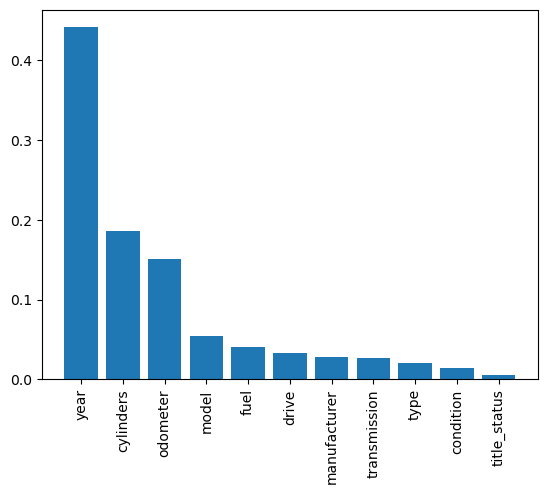

In [110]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

In [111]:
end_time = time.time()
runtime = end_time - start_time
print("Total runtime:",runtime)

Total runtime: 116.19417762756348
